<a href="https://colab.research.google.com/github/Playmen998/Data-Analysis/blob/master/A_B_test_design_website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи

Вы работаете в стартапе на ранней стадии в Германии. Ваша команда работала над редизайном целевой страницы. Команда считает, что новый дизайн увеличит количество людей, которые переходят на ваш сайт и присоединяются к нему.

Они тестировали изменения в течение нескольких недель, и теперь они хотят измерить влияние изменения и нуждаются в вас, чтобы определить, может ли увеличение быть связано со случайностью или оно является статистически значимым.

- "treatment" - "yes" если пользователь увидел новую версию лендинга, иначе нет.
- "new_images" - "yes" если на странице использовался новый набор изображений, иначе нет.
- "converted" - 1 если на странице использовался новый набор изображений, иначе нет.

Контрольная группа — это те пользователи, у которых в обоих столбцах указано «нет»: старая версия со старым набором изображений.

1. Проанализируйте показатели конверсии для каждой из четырех групп: новый/старый дизайн целевой страницы и новые/старые картинки.
2. Можно ли объяснить наблюдаемое увеличение случайностью? (Подсказка: представьте A/B-тест)
3. Какую версию веб-сайта им следует использовать?

# Разведывательный анализ

https://drive.google.com/file/d/1JU2Z6EQqhNQFqN3zPiG9XTFjRpabYw_8/view?usp=sharing

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.style.use('ggplot')

In [ ]:
! gdown --id 1JU2Z6EQqhNQFqN3zPiG9XTFjRpabYw_8

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1JU2Z6EQqhNQFqN3zPiG9XTFjRpabYw_8
To: /content/redesign.csv
100% 364k/364k [00:00<00:00, 9.30MB/s]


In [ ]:
df = pd.read_csv('/content/redesign.csv')

In [ ]:
df.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


In [ ]:
len(df)

40484

Кол-во строк в df

In [ ]:
df.isna().mean()

treatment     0.0
new_images    0.0
converted     0.0
dtype: float64

Пропусков нет

Напишем функцию, которая приводит данные в удобный формат:  
+ Группа А: старый сайт - старые картинки  
+ Группа В: старый сайт - новые картинки
+ Группа С: новый сайт - старые картинки
+ Группа D: новый сайт - новые картинки

In [ ]:
def map_group(row):
  if row['treatment'] == 'no' and row['new_images'] == 'no': # Старый сайт - старые картинки A
    return 'A'
  elif row['treatment'] == 'no' and row['new_images'] == 'yes': # Старый сайт - новые картинки B
    return 'B'
  elif row['treatment'] == 'yes' and row['new_images'] == 'no': # Новый сайт - старые картинки C
    return 'C'
  elif row['treatment'] == 'yes' and row['new_images'] == 'yes': # Новый сайт - новые картинки D
    return 'D'

In [ ]:
df['group'] = df.apply(lambda row: map_group(row), axis = 1)

In [ ]:
df.head()

,treatment,new_images,converted,group
0,yes,yes,0,D
1,yes,yes,0,D
2,yes,yes,0,D
3,yes,no,0,C
4,no,yes,0,B


In [ ]:
df.groupby('group').count()

,treatment,new_images,converted
group,,,
A,10121,10121,10121
B,10121,10121,10121
C,10121,10121,10121
D,10121,10121,10121


Группы сбалансированные. В каждой группе по 10121 наблюдений

In [ ]:
df_group = df.groupby(['group','converted'])["treatment"].agg(['count']).reset_index()

In [ ]:
df_group

,group,converted,count
0,A,0,9037
1,A,1,1084
2,B,0,8982
3,B,1,1139
4,C,0,8906
5,C,1,1215
6,D,0,8970
7,D,1,1151


In [ ]:
df_main = df_group.groupby("group").agg({'count':['min','max','sum']}).droplevel(level=0, axis=1)

In [ ]:
df_main["cr"] = df_main["min"] / df_main["sum"]

In [ ]:
df_main.sort_values(by = 'cr')

,min,max,sum,cr
group,,,,
A,1084,9037,10121,0.107104
B,1139,8982,10121,0.112538
D,1151,8970,10121,0.113724
C,1215,8906,10121,0.120047


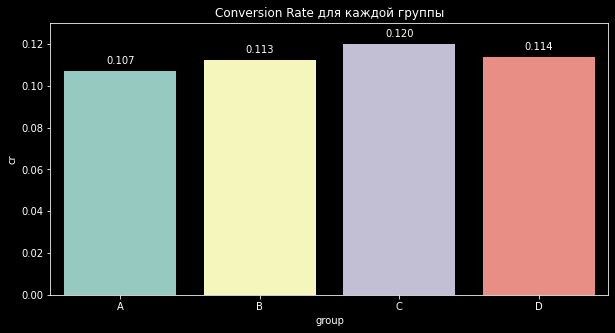

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_main, x=df_main.index,y='cr')
for p in ax.patches:
	ax.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 	'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.set_title('Conversion Rate для каждой группы')
ax.set_ylim(0.0, df_main['cr'].max()+0.01)
plt.show()

Мы получили конверсии для каждой группы.  
Для группы А (старый сайт - старые картинки) получили самую маленькую конверсию = 0.107104  
Для группы С (новый сайт - старые картинки) получили самую большую конверсию = 0.120047

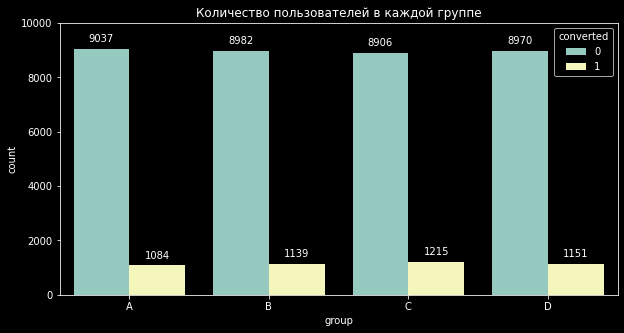

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df, x='group',hue='converted',order=['A','B','C','D'])
for p in ax.patches:
	ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 	'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ax.set_ylim(0, 10000)
ax.set_title('Количество пользователей в каждой группе')
plt.show()

Количество пользователей в каждой группе в разрезе конверсии

# Проверка результатов A/B теста критерием Даннета

Нам необходимо выяснить, являются ли полученные результаты статистически значимы.  
Для этого воспользуемся тестом Даннета, который сравнивает экспериментальные группы с контрольной. Почему мы можем его использовать?  
+ Тест Даннета является неким аналогом многофакторного дисперсионного анализа (ANOVA). В отличие от ANOVA тест Даннета позволяет нам проводить попарные сравнения между средними значениями каждой группы. Также нет необходимости проводить общий тест ANOVA перед тестом Даннета для проверки H0: принадлежат ли эти выборки к одной генеральной совокупности т.к. сами апостериорные тесты (в частности тест Даннета) контролирует уровень alpha (https://stats.stackexchange.com/questions/9751/do-we-need-a-global-test-before-post-hoc-tests) 
+ Тест Даннета является достаточно робастым (https://link.springer.com/chapter/10.1007/978-94-009-6528-7_29), что позволяет невелировать нормальное распределение данных, даже если бы оно не было нормальным, то когда выборка является большой, биномиальное распределение может быть аппроксимировано нормальным распределением (https://docs.exponenta.ru/stats/binomial-distribution.html)  
Таким образом, мы смело можем использовать тест Даннета


Установим необходимую библиотеку

In [ ]:
!pip install scikit-posthocs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Выдвиним гипотезы:  
H0: Группы принадлежат к одной генеральной совокупности, а значит полученные значения не статистически значимы  
H1: Группы принадлежат к разным генеральным совокупностям, значит различия статистически значимы

In [ ]:
group1 = df[df['group'] == 'A']['converted']
group2 = df[df['group'] == 'B']['converted']
group3 = df[df['group'] == 'C']['converted']
group4 = df[df['group'] == 'D']['converted']
data = [group1, group2, group3, group4]

In [ ]:
import scikit_posthocs as sp

In [ ]:
sp.posthoc_dunn(data, p_adjust = 'bonferroni')

,1,2,3,4
1,1.000000,1.000000,0.022082,0.824591
2,1.000000,1.000000,0.551981,1.000000
3,0.022082,0.551981,1.000000,0.935549
4,0.824591,1.000000,0.935549,1.000000


В таблице представлены значения p-value для разных пар групп:  
+ 1 - 2 (A - B) значение p-value = 1 -> мы принимаем H0 -> не статистические значимые результаты
+ 1 - 3 (A - С) значение p-value = 0.022082 -> мы отбрасываем H0 -> значения статистические значимые
+ 1 - 4 (A - D) значение p-value = 0.824591 -> мы принимаем H0 -> не статистические значимые результаты  
+ 2 - 3 (B - С) значение p-value = 0.551981 -> мы принимаем H0 -> не статистические значимые результаты 
+ 2 - 4 (B - D) значение p-value = 1 -> мы принимаем H0 -> не статистические значимые результаты 
+ 3 - 4 (C - D) значение p-value = 0.935549 -> мы принимаем H0 -> не статистические значимые результаты  

PS: Данные результаты учитываются с поправкой Бонферрони 

# Проверим полученные результаты методом Bootstrap с поправкой Бонферрони 

Напишем метод, который будет считать p-value для двух выборок.  
Также применим поправку Бонферрони $ α_m = α/m $, где m - кол-во гипотез, α - уровень значимости. Данная поправка сделает нашу проверку достаточно консервативной для принятия решений об H0.  
https://r-analytics.blogspot.com/2013/10/blog-post_13.html

Выдвиним гипотезы:  
H0: Группы принадлежат к одной генеральной совокупности, а значит полученные значения не статистически значимы  
H1: Группы принадлежат к разным генеральным совокупностям, значит различия статистически значимы

In [ ]:
0.05 / 6

0.008333333333333333

Уровень α в нашем случае = 0.0083

In [ ]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

## Тест А - B

In [ ]:
sample_1 = df[df["group"] == 'A']["converted"]

In [ ]:
sample_2 = df[df["group"] == 'B']["converted"]

  0%|          | 0/1000 [00:00<?, ?it/s]

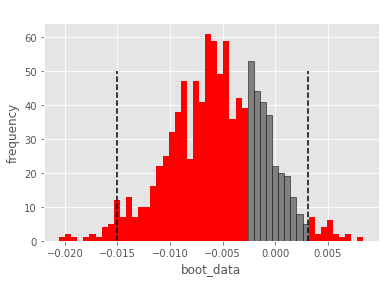

In [ ]:
booted_data = get_bootstrap(sample_1, sample_2)

In [ ]:
booted_data["p_value"]

0.2277246028450689

Для группы A - B уровень значимости = 0.227, что больше 0.0083, значит принимаем H0 -> нет статистических различий

## Тест A - C

In [ ]:
sample_1 = df[df["group"] == 'A']["converted"]

In [ ]:
sample_2 = df[df["group"] == 'C']["converted"]

  0%|          | 0/1000 [00:00<?, ?it/s]

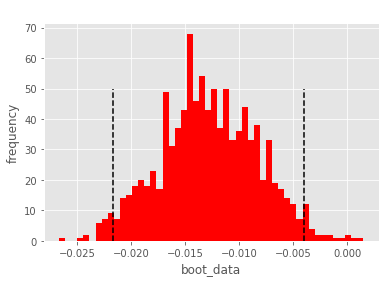

In [ ]:
booted_data = get_bootstrap(sample_1, sample_2)

In [ ]:
booted_data["p_value"]

0.0043872057473828465

Для группы A - C уровень значимости = 0.0043, что меньше $α_m$, значит отвергаем H0 -> статистические *значимы* различия

## Тест A - D 

In [ ]:
sample_1 = df[df["group"] == 'A']["converted"]

In [ ]:
sample_2 = df[df["group"] == 'D']["converted"]

  0%|          | 0/1000 [00:00<?, ?it/s]

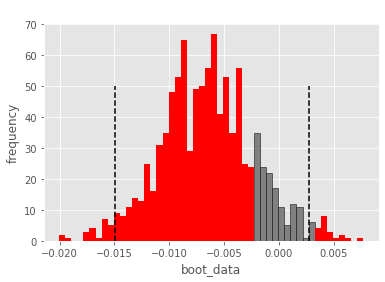

In [ ]:
booted_data = get_bootstrap(sample_1, sample_2)

In [ ]:
booted_data["p_value"]

0.12900352733013695

Для группы A - D уровень значимости = 0.1290, что больше $α_m$, значит принимаем H0 -> нет статистических различий

## Тест B - C

In [ ]:
sample_1 = df[df["group"] == 'B']["converted"]

In [ ]:
sample_2 = df[df["group"] == 'C']["converted"]

  0%|          | 0/1000 [00:00<?, ?it/s]

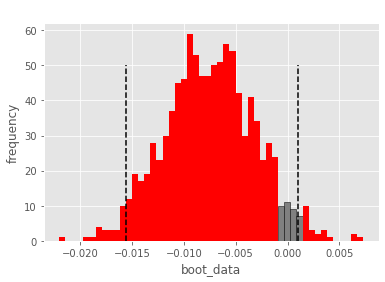

In [ ]:
booted_data = get_bootstrap(sample_1, sample_2)

In [ ]:
booted_data["p_value"]

0.08421490927964569

Для группы B - C уровень значимости = 0.084, что больше $α_m$, значит принимаем H0 -> нет статистических различий

## Тест B - D

In [ ]:
sample_1 = df[df["group"] == 'B']["converted"]

In [ ]:
sample_2 = df[df["group"] == 'D']["converted"]

  0%|          | 0/1000 [00:00<?, ?it/s]

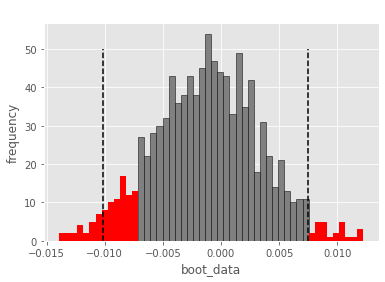

In [ ]:
booted_data = get_bootstrap(sample_1, sample_2)

In [ ]:
booted_data["p_value"]

0.7877705041701574

Для группы B - D уровень значимости = 0.7877, что больше $α_m$, значит принимаем H0 -> нет статистических различий

## Тест C - D

In [ ]:
sample_1 = df[df["group"] == 'C']["converted"]

In [ ]:
sample_2 = df[df["group"] == 'D']["converted"]

  0%|          | 0/1000 [00:00<?, ?it/s]

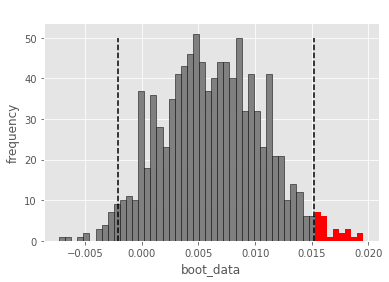

In [ ]:
booted_data = get_bootstrap(sample_1, sample_2)

In [ ]:
booted_data["p_value"]

0.1635347713356866

Для группы C - D уровень значимости = 0.163, что больше $α_m$, значит принимаем H0 -> нет статистических различий

Как мы видим, для всех групп подтвердились результаты, которые мы получили с помощью теста Даннета

# Построение доверительных интервалов

Построим доверительные интервалы для каждой пары групп

In [ ]:
from scipy import stats
def get_ci(test_conv, con_conv, test_size, con_size, ci):
  sd = ((test_conv * (1 - test_conv)) / test_size + (con_conv * (1 - con_conv)) / con_size)** 0.5
  lift = test_conv - con_conv

  val = stats.norm.isf((1 - ci) / 2)
  lwr_bnd = lift - val * sd
  upr_bnd = lift + val * sd
  return((lwr_bnd,upr_bnd))

In [ ]:
df_main

,min,max,sum,cr
group,,,,
A,1084,9037,10121,0.107104
B,1139,8982,10121,0.112538
C,1215,8906,10121,0.120047
D,1151,8970,10121,0.113724


In [ ]:
get_ci(0.120047,0.107104,10121,10121, 0.95)

(0.004202742441096797, 0.021683257558903195)

In [ ]:
A_cr = df_main.iloc[0]["cr"]
B_cr = df_main.iloc[1]["cr"]
C_cr = df_main.iloc[2]["cr"]
D_cr = df_main.iloc[3]["cr"]
sample_size = 10121
p_value = 0.95

In [ ]:
get_ci(B_cr,A_cr,sample_size,sample_size, p_value)

(-0.0031799876908947984, 0.014048478946699573)

In [ ]:
get_ci(C_cr,A_cr,sample_size,sample_size, p_value)

(0.004203119749539921, 0.021683650332467788)

In [ ]:
get_ci(D_cr,A_cr,sample_size,sample_size, p_value)

(-0.002014520978317679, 0.015254319417207129)

In [ ]:
get_ci(C_cr,B_cr,sample_size,sample_size, p_value)

(-0.0013227229053725358, 0.01634100173157547)

In [ ]:
get_ci(D_cr,B_cr,sample_size,sample_size, p_value)

(-0.007541474618747646, 0.009912781801832322)

In [ ]:
get_ci(C_cr,D_cr,sample_size,sample_size, p_value)

(-0.0025280670644226722, 0.015175038707540932)

In [ ]:
data_dict = {}
data_dict['category'] = ['B - A','C - A','D - A', 'C - B', 'D - B','C - D']
data_dict['lower'] = [-0.0031,0.0042,-0.0020,-0.0013,-0.0075,-0.0025]
data_dict['upper'] = [0.0140,0.0216,0.0152,0.0163,0.0099,0.0151]
dataset = pd.DataFrame(data_dict)

([<matplotlib.axis.YTick at 0x7f30f63f1950>,
 [Text(0, 0, 'B - A'),
  Text(0, 0, 'C - A'),
  Text(0, 0, 'D - A'),
  Text(0, 0, 'C - B'),
  Text(0, 0, 'D - B'),
  Text(0, 0, 'C - D')])

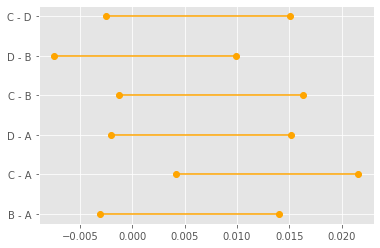

In [ ]:
for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-',color='orange')
plt.yticks(range(len(dataset)),list(dataset['category']))

Получили грфик доверительных интервалов для каждой из групп, на котором видно, что группа A-C не пересекает 0, а значит имеет статистические значимые результаты

# Итоги

По результатам теста Даннета, мы получили, что группа С (новый сайт, старые картинки) имеет p-value = 0.022, которая говорит нам о том, что вероятность получить статистически значимые результаты равна $0.978 = 1 - 0.022$. Также группа C имеет самую большую конверсию среди всех остальных групп равную 0.12 с доверительным интервалом средних различий (от 0.0042 до 0.0216), который говорит нам о том, что в этом интервале расположено истинное среднее значение различий между конверсией группы A и C (то насколько конверсия группы C может изменится по сравнению с группой A)  
Поэтому, я рекомендую вариант с новым сайтом и старыми картинками (C), который однозначно изменит конверсию в лучшую сторону от 0.0042 до 0.0216 от первоначального варианта (старый сайт, старые картинки - A) 

По остальным группам B (старый сайт, новые картинки) и D (новый сайт, новые картинки) нельзя однозначно утверждать, что проведенные эксперименты являются статистически значимыми, также группы B и D показали конверсию меньше, чем группа C и тоже самое мы наблюдаем, если смотреть на доверительные интервалы, поэтому я рекомендую отбросить эти варианты. 